In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [5]:
def multi_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(8, (1, 1), activation='softmax')(c9)

     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [6]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [7]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=7 #Number of classes for segmentation

In [8]:
image_directory = r"C:\Users\user\Documents\unet_dataset_resized\Images"
mask_directory = r"C:\Users\user\Documents\unet_dataset_resized\Masks"

In [9]:
#listing data
image_dataset = []    
mask_dataset = []

In [10]:
# Process images
images = os.listdir(image_directory)
for image_name in images:
    if image_name.lower().endswith('.tif'):
        image_path = os.path.join(image_directory, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            # Uncomment the following line if resizing is desired
            # image = cv2.resize(image, (SIZE, SIZE))
            image_dataset.append(image)
        else:
            print(f"Failed to load image: {image_path}")

In [11]:
# Report the results
print(f"Total images: {len(image_dataset)}")

# Convert the lists to numpy arrays if needed
image_dataset = np.array(image_dataset, dtype=np.uint8)

# Check the shapes to confirm sizes
print(f"Image dataset shape: {image_dataset.shape}")

Total images: 18
Image dataset shape: (18, 256, 256)


In [12]:
np.unique(image_dataset)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [13]:
# Correct class mapping with 0 included for the background
class_mapping = {
    'Background': 0,
    'BrokenBeans': 1,
    'BrokenFraction': 2,
    'Fermented': 3,
    'Mouldy': 4,
    'SkinDamage': 5,
    'Unfermented': 6,
    'WholeBean': 7
}

In [14]:
# Now, update the labeled masks using the corrected mapping
import re

labeled_masks = []  # Clear any previous labeling work

for mask_file in glob.glob(os.path.join(mask_directory, "*.tif")):
    # Use regular expression to extract the class name from the file name
    class_name_match = re.match(r"([a-zA-Z]+)_", os.path.basename(mask_file))
    if class_name_match:
        class_name = class_name_match.groups()[0]
        label = class_mapping.get(class_name, 0)  # Default to background if not found

        # Load and process the mask
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_X, SIZE_Y))
        labeled_mask = np.where(mask > 0, label, 0)  # Apply the label, preserve background

        labeled_masks.append(labeled_mask)
        print(f"{mask_file}: Unique labeled values - {np.unique(labeled_mask)}")

C:\Users\user\Documents\unet_dataset_resized\Masks\BrokenBeans_1.tif: Unique labeled values - [0 1]
C:\Users\user\Documents\unet_dataset_resized\Masks\BrokenBeans_2.tif: Unique labeled values - [0 1]
C:\Users\user\Documents\unet_dataset_resized\Masks\BrokenFraction_1.tif: Unique labeled values - [0 2]
C:\Users\user\Documents\unet_dataset_resized\Masks\Fermented_1.tif: Unique labeled values - [0 3]
C:\Users\user\Documents\unet_dataset_resized\Masks\Fermented_2.tif: Unique labeled values - [0 3]
C:\Users\user\Documents\unet_dataset_resized\Masks\Fermented_3.tif: Unique labeled values - [0 3]
C:\Users\user\Documents\unet_dataset_resized\Masks\Mouldy_1.tif: Unique labeled values - [0 4]
C:\Users\user\Documents\unet_dataset_resized\Masks\Mouldy_2.tif: Unique labeled values - [0 4]
C:\Users\user\Documents\unet_dataset_resized\Masks\Mouldy_3.tif: Unique labeled values - [0 4]
C:\Users\user\Documents\unet_dataset_resized\Masks\SkinDamage_1.tif: Unique labeled values - [0 5]
C:\Users\user\Docum

In [15]:
# Assuming labeled_masks is a list of numpy arrays
labeled_masks_array = np.stack(labeled_masks, axis=0)

In [16]:
from keras.utils import to_categorical

# Convert integer masks to one-hot encoding
mask_dataset_one_hot = to_categorical(labeled_masks_array, num_classes=8)  # 7 bean conditions + 1 background = 8 classes
print("Shape of one-hot encoded masks:", mask_dataset_one_hot.shape)


Shape of one-hot encoded masks: (18, 256, 256, 8)


In [17]:
# splititng dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_one_hot, test_size=0.20, random_state=0
)

In [18]:
#Normalizing image dataset

# Assuming image_dataset is a numpy array of images
X_train = np.expand_dims(X_train, axis=3)  # Ensure it has a proper shape
X_train = normalize(X_train, axis=1)

X_test = np.expand_dims(X_test, axis=3)  # Ensure it has a proper shape
X_test = normalize(X_test, axis=1)


In [19]:
#Model compilation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

model = multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
____________________________________________________________________________________________

In [67]:
#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=8, 
    epochs=50, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Train on 14 samples, validate on 4 samples
Epoch 1/50
14/14 [==============================] - 4s 251ms/step - loss: 2.0740 - accuracy: 0.0720 - val_loss: 1.9380 - val_accuracy: 0.3606
Epoch 2/50
14/14 [==============================] - 3s 197ms/step - loss: 2.6115 - accuracy: 0.3283 - val_loss: 1.8571 - val_accuracy: 0.6688
Epoch 3/50
14/14 [==============================] - 3s 192ms/step - loss: 1.8340 - accuracy: 0.5554 - val_loss: 2.0068 - val_accuracy: 0.7010
Epoch 4/50
14/14 [==============================] - 3s 193ms/step - loss: 1.9854 - accuracy: 0.6421 - val_loss: 2.0032 - val_accuracy: 0.7010
Epoch 5/50
14/14 [==============================] - 3s 205ms/step - loss: 1.9888 - accuracy: 0.6464 - val_loss: 1.9823 - val_accuracy: 0.7010
Epoch 6/50
14/14 [==============================] - 3s 199ms/step - loss: 1.9677 - accuracy: 0.6467 - val_loss: 1.9512 - val_accuracy: 0.7010
Epoch 7/50
14/14 [==============================] - 3s 196ms/step - loss: 1.9342 - accuracy: 0.6467 - val

In [84]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 31ms/step
Accuracy =  67.07725524902344 %


In [85]:
#Iou score 
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6039652242265884


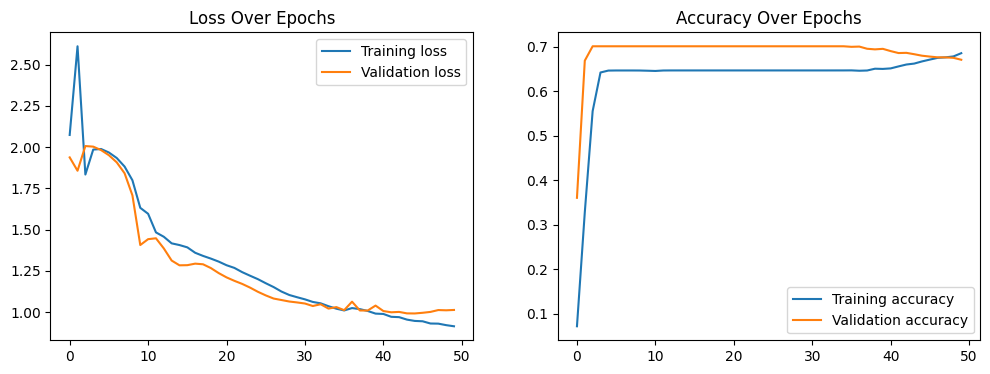

In [71]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


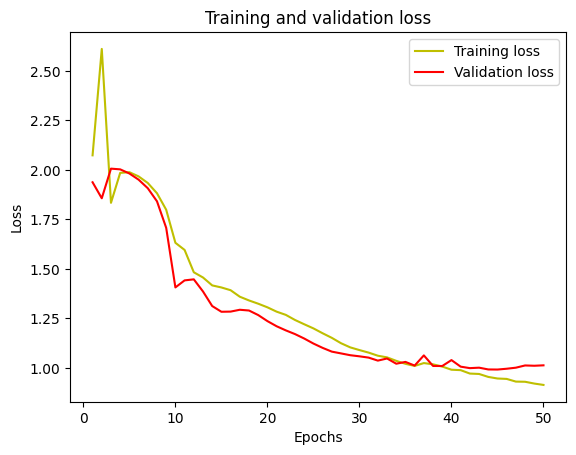

In [72]:
#plot the training and validation accuracy and loss at each epoch @100Epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

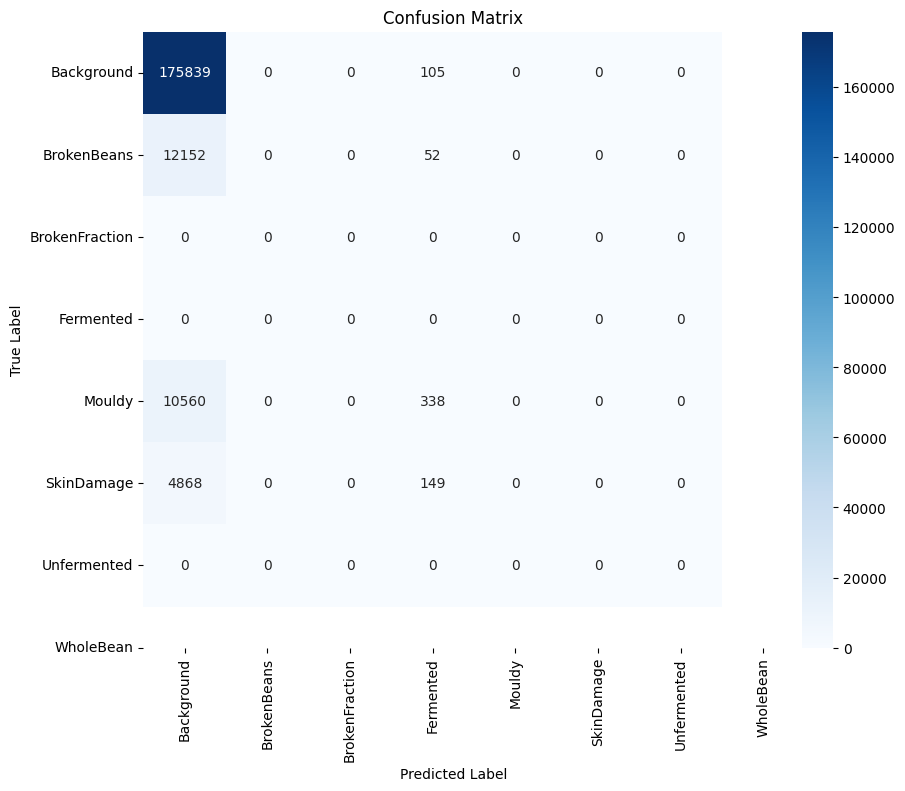

In [78]:
#Confusion matrix

# Predict on the entire test dataset
predictions = model.predict(X_test)

# Flatten the predictions and true masks
y_pred = np.argmax(predictions, axis=3).flatten()
y_true = np.argmax(y_test, axis=3).flatten()


from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))


import seaborn as sns

# Define the class names for the confusion matrix
class_names = ['Background', 'BrokenBeans', 'BrokenFraction', 'Fermented', 'Mouldy', 'SkinDamage', 'Unfermented', 'WholeBean']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


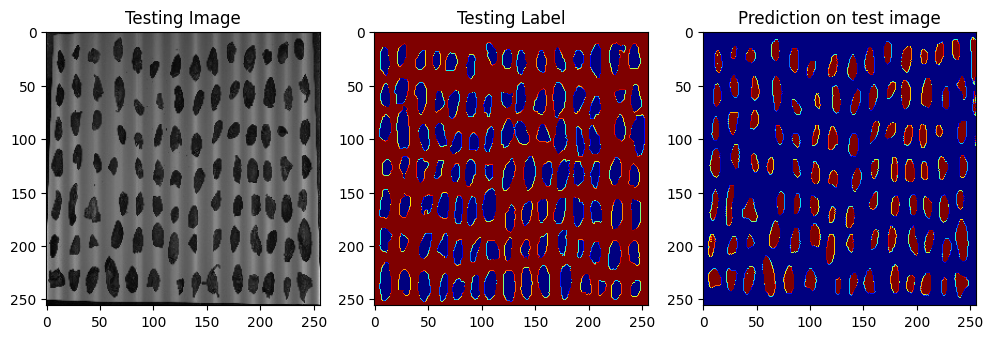

In [81]:
#prediction on some images 
import random

test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()


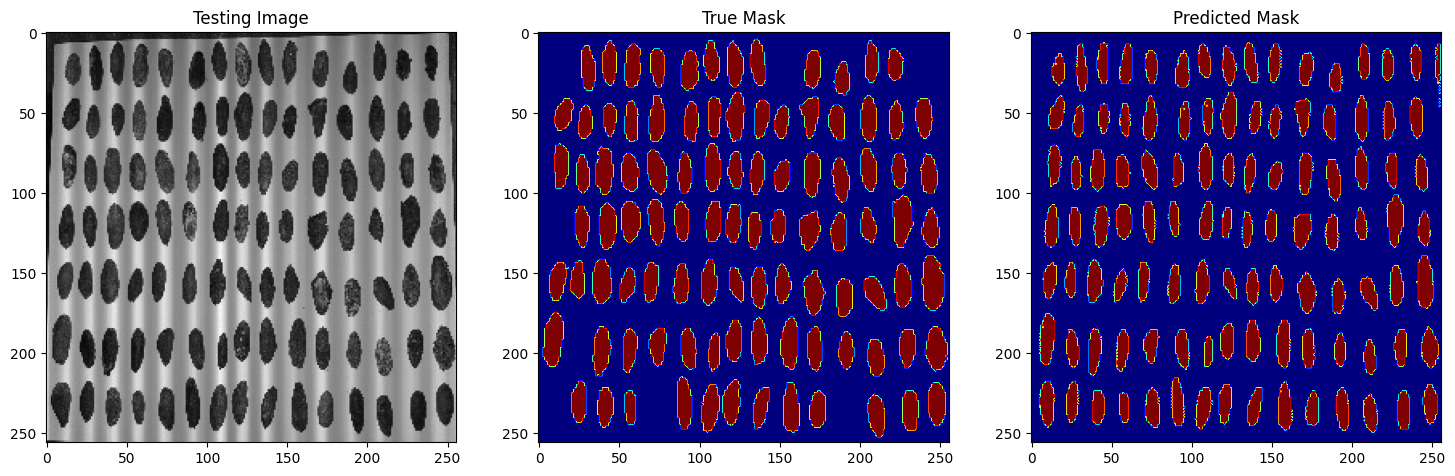

Classes predicted in the image: ['Background', 'Fermented', 'WholeBean']


In [83]:
#Mask and prediction class

import random

# Randomly select an image and its corresponding mask from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[random_index]
test_mask = y_test[random_index]


# Expand dimensions of the image to fit the model input shape and predict the mask
test_img_input = np.expand_dims(test_img, axis=0)
predicted_mask = model.predict(test_img_input)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]


# Visualize the testing image, the true mask, and the predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('Testing Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')

plt.show()


# Get unique classes predicted in the image
predicted_classes = np.unique(predicted_mask)
predicted_class_names = [class_names[i] for i in predicted_classes]

print("Classes predicted in the image:", predicted_class_names)



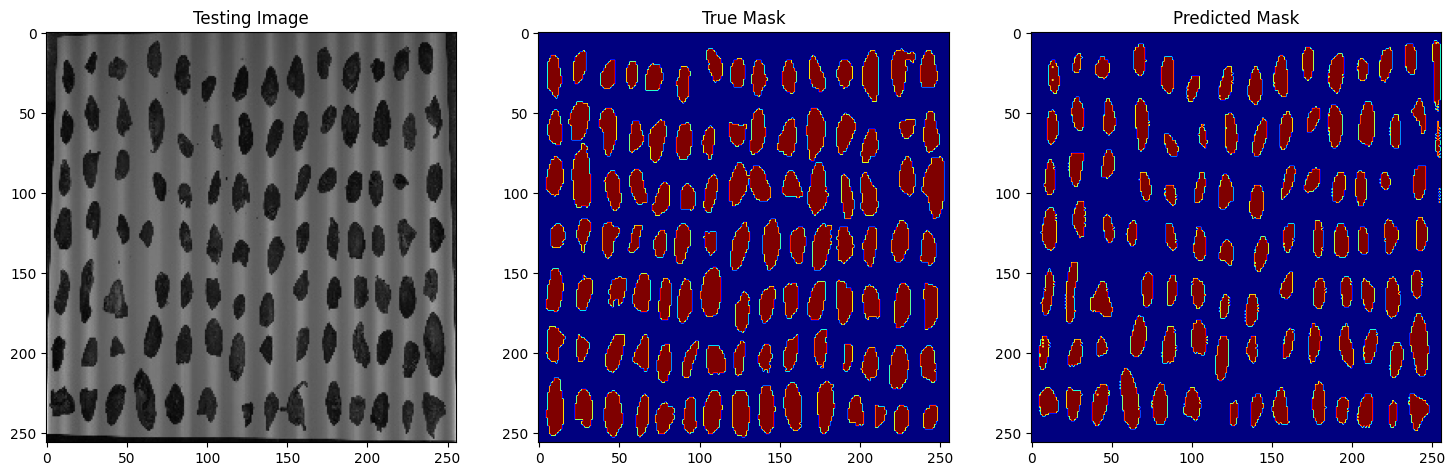

Classes predicted in the image: ['Background', 'Fermented', 'WholeBean']


In [95]:
#Mask and prediction class

import random

# Randomly select an image and its corresponding mask from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[random_index]
test_mask = y_test[random_index]


# Expand dimensions of the image to fit the model input shape and predict the mask
test_img_input = np.expand_dims(test_img, axis=0)
predicted_mask = model.predict(test_img_input)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]


# Visualize the testing image, the true mask, and the predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('Testing Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')

plt.show()


# Get unique classes predicted in the image
predicted_classes = np.unique(predicted_mask)
predicted_class_names = [class_names[i] for i in predicted_classes]

print("Classes predicted in the image:", predicted_class_names)

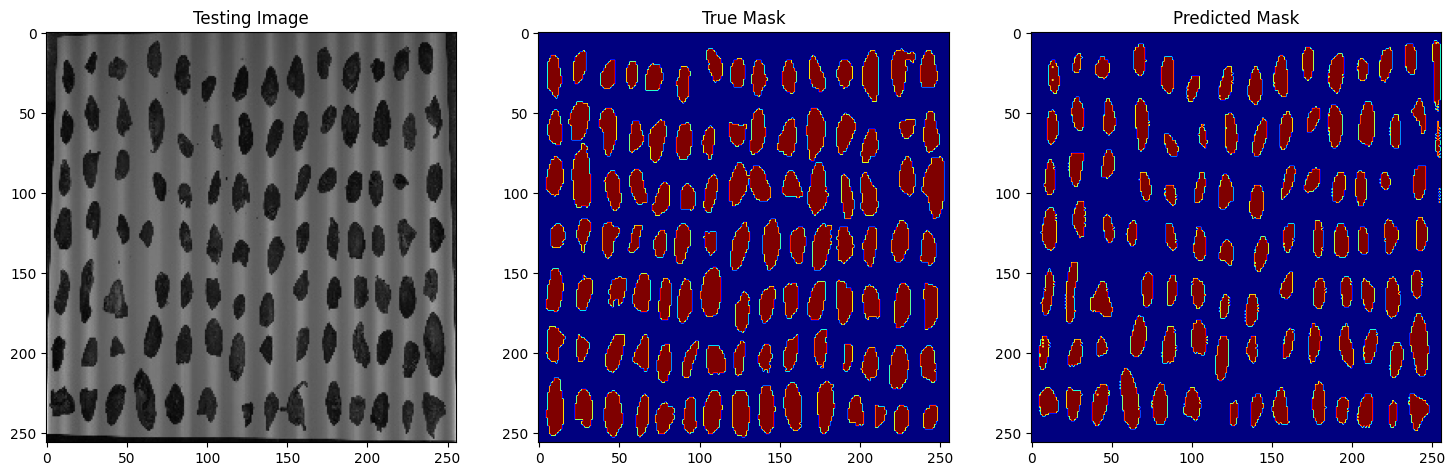

The most common predicted bean class is: WholeBean


In [92]:
#Mask and prediction class

import random

# Randomly select an image and its corresponding mask from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[random_index]
test_mask = y_test[random_index]


# Expand dimensions of the image to fit the model input shape and predict the mask
test_img_input = np.expand_dims(test_img, axis=0)
predicted_mask = model.predict(test_img_input)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]


# Visualize the testing image, the true mask, and the predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('Testing Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')

plt.show()


# Get unique classes predicted in the image
predicted_classes = np.unique(predicted_mask)
predicted_class_names = [class_names[i] for i in predicted_classes]

print("Classes predicted in the image:", predicted_class_names)

In [94]:
#The predicted class
from scipy.stats import mode

# Find the most common non-background class in the predicted mask
bean_classes = predicted_mask[predicted_mask != 0]  # Exclude the background
if bean_classes.size > 0:
    most_common_bean_class = mode(bean_classes).mode[0]
    print(f"The most common predicted bean class is: {class_names[most_common_bean_class]}")
else:
    print("No beans detected in the image.")


The most common predicted bean class is: WholeBean


In [ ]:
################################### Hyperparameter tunning step 1##################################

In [65]:
#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=16, 
    epochs=48, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Train on 14 samples, validate on 4 samples
Epoch 1/48
14/14 [==============================] - 3s 202ms/step - loss: 0.6232 - accuracy: 0.7492 - val_loss: 0.8957 - val_accuracy: 0.7193
Epoch 2/48
14/14 [==============================] - 3s 193ms/step - loss: 0.6220 - accuracy: 0.7477 - val_loss: 0.8988 - val_accuracy: 0.7217
Epoch 3/48
14/14 [==============================] - 3s 195ms/step - loss: 0.6239 - accuracy: 0.7487 - val_loss: 0.9051 - val_accuracy: 0.7229
Epoch 4/48
14/14 [==============================] - 3s 195ms/step - loss: 0.6148 - accuracy: 0.7534 - val_loss: 0.9040 - val_accuracy: 0.7231
Epoch 5/48
14/14 [==============================] - 3s 196ms/step - loss: 0.6159 - accuracy: 0.7514 - val_loss: 0.8917 - val_accuracy: 0.7237
Epoch 6/48
14/14 [==============================] - 3s 210ms/step - loss: 0.6024 - accuracy: 0.7554 - val_loss: 0.8785 - val_accuracy: 0.7243
Epoch 7/48
14/14 [==============================] - 3s 198ms/step - loss: 0.6003 - accuracy: 0.7591 - val

In [66]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 38ms/step
Accuracy =  77.67181396484375 %


In [67]:
#Iou score 
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6212956731654563


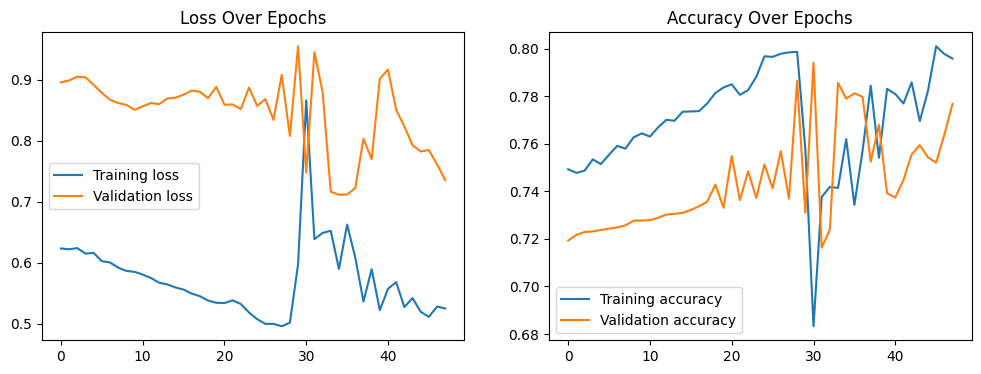

In [68]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

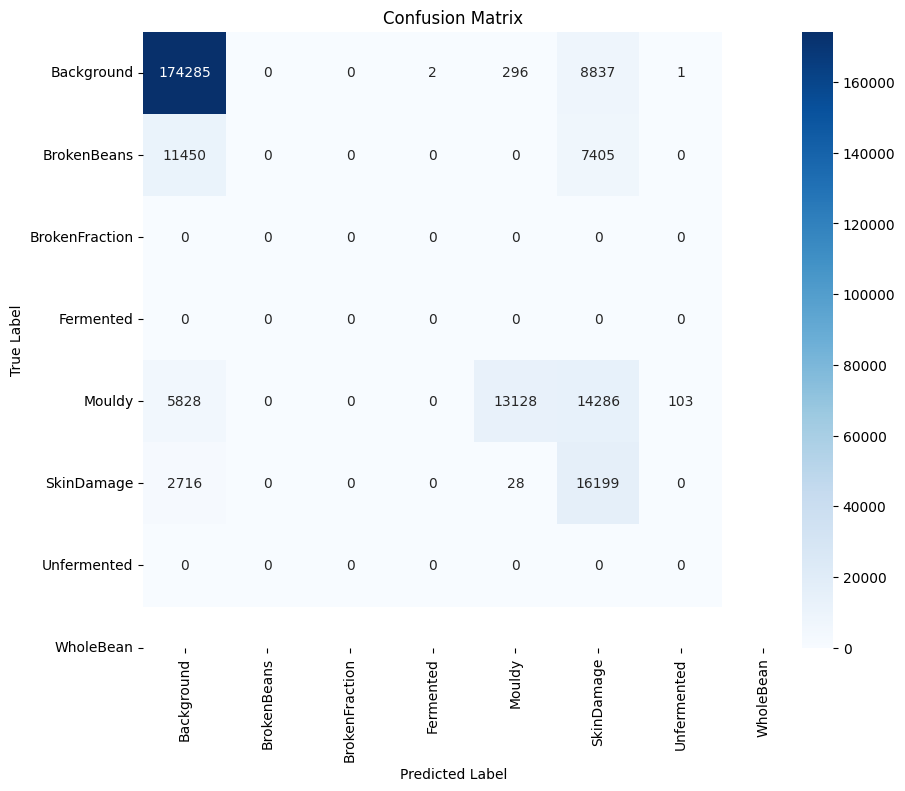

In [69]:
#Confusion matrix

# Predict on the entire test dataset
predictions = model.predict(X_test)

# Flatten the predictions and true masks
y_pred = np.argmax(predictions, axis=3).flatten()
y_true = np.argmax(y_test, axis=3).flatten()


from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))


import seaborn as sns

# Define the class names for the confusion matrix
class_names = ['Background', 'BrokenBeans', 'BrokenFraction', 'Fermented', 'Mouldy', 'SkinDamage', 'Unfermented', 'WholeBean']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


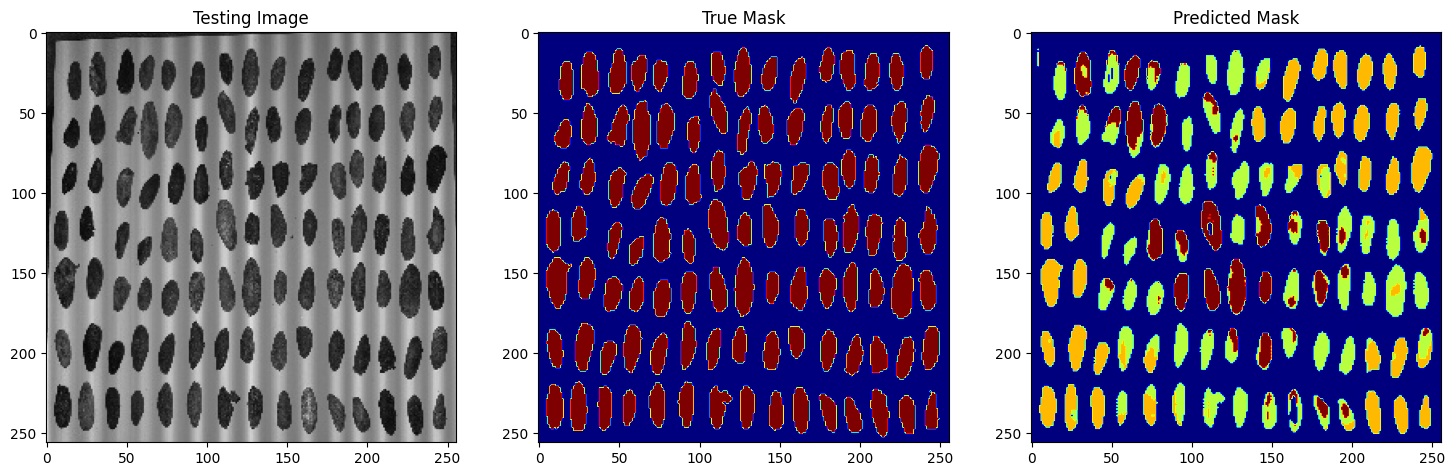

Classes predicted in the image: ['Background', 'Mouldy', 'SkinDamage', 'Unfermented', 'WholeBean']


In [79]:
#Mask and prediction class

import random

# Randomly select an image and its corresponding mask from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[random_index]
test_mask = y_test[random_index]


# Expand dimensions of the image to fit the model input shape and predict the mask
test_img_input = np.expand_dims(test_img, axis=0)
predicted_mask = model.predict(test_img_input)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]


# Visualize the testing image, the true mask, and the predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('Testing Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')

plt.show()


# Get unique classes predicted in the image
predicted_classes = np.unique(predicted_mask)
predicted_class_names = [class_names[i] for i in predicted_classes]

print("Classes predicted in the image:", predicted_class_names)

In [106]:
###### Tesing diferent RMS optimizer ############

#Model Using RMS prop
from keras.optimizers import RMSprop

model = multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 256, 256, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 16) 2320        dropout_19[0][0]                 
____________________________________________________________________________________________

In [107]:
#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=8, 
    epochs=50, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Train on 14 samples, validate on 4 samples
Epoch 1/50
14/14 [==============================] - 4s 255ms/step - loss: 2.0725 - accuracy: 0.1498 - val_loss: 5.8254 - val_accuracy: 0.3529
Epoch 2/50
14/14 [==============================] - 3s 189ms/step - loss: 5.2658 - accuracy: 0.4250 - val_loss: 1.9626 - val_accuracy: 0.6897
Epoch 3/50
14/14 [==============================] - 3s 192ms/step - loss: 1.9304 - accuracy: 0.5660 - val_loss: 1.8373 - val_accuracy: 0.6887
Epoch 4/50
14/14 [==============================] - 3s 191ms/step - loss: 1.6678 - accuracy: 0.5814 - val_loss: 1.8846 - val_accuracy: 0.7005
Epoch 5/50
14/14 [==============================] - 3s 192ms/step - loss: 1.8254 - accuracy: 0.6370 - val_loss: 1.7168 - val_accuracy: 0.7005
Epoch 6/50
14/14 [==============================] - 3s 193ms/step - loss: 1.6709 - accuracy: 0.6379 - val_loss: 1.8437 - val_accuracy: 0.7008
Epoch 7/50
14/14 [==============================] - 3s 192ms/step - loss: 1.8018 - accuracy: 0.6422 - val

In [111]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 38ms/step
Accuracy =  70.10345458984375 %


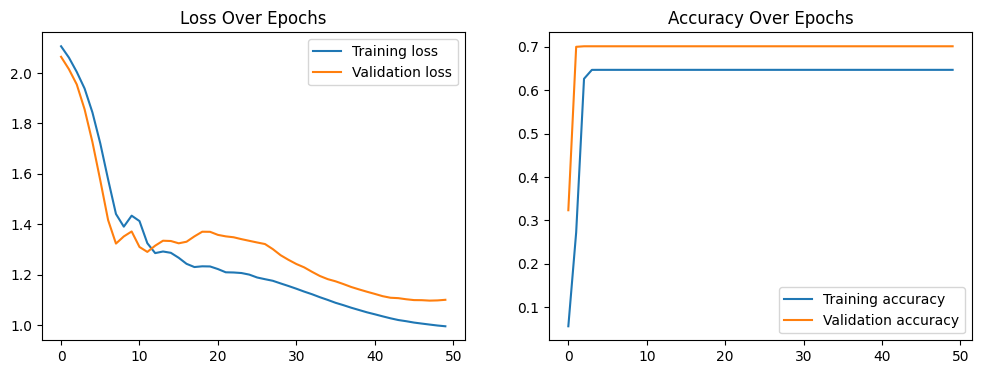

In [23]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [109]:
###### Tesing diferent adagrad optimizer @ 8Epochs ############

#Model Using RMS prop
from keras.optimizers import Adagrad

model = multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(optimizer=Adagrad(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=8, 
    epochs=50, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 256, 256, 16) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 16) 2320        dropout_28[0][0]                 
____________________________________________________________________________________________

In [112]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 37ms/step
Accuracy =  70.10345458984375 %


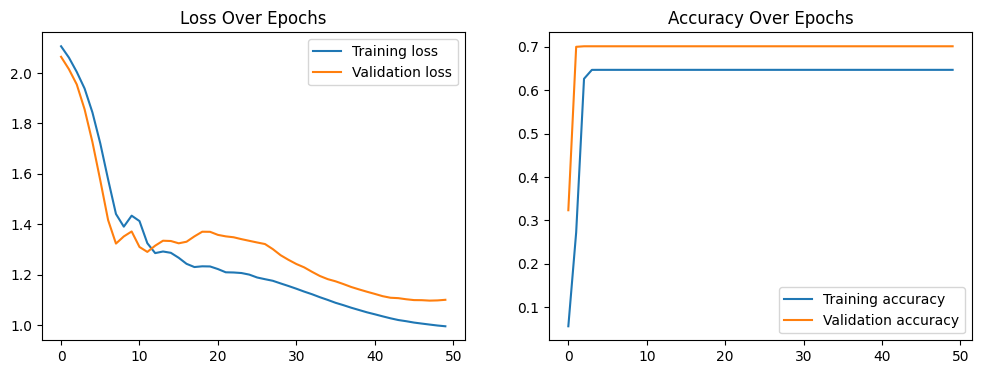

In [24]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [19]:
###### Tesing diferent adagrad optimizer @16 Epochs ############

#Model Using RMS prop
from keras.optimizers import Adagrad

model = multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(optimizer=Adagrad(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=16, 
    epochs=50, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
____________________________________________________________________________________________

In [20]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 37ms/step
Accuracy =  70.10345458984375 %


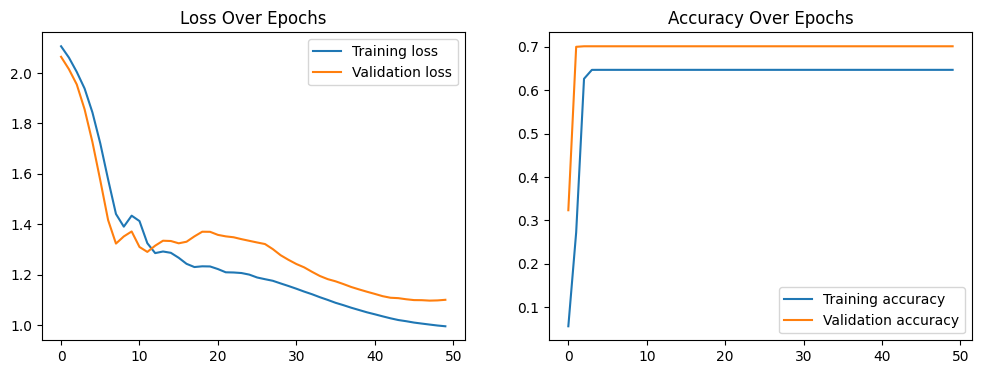

In [25]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [21]:
###### Tesing diferent SGD optimizer @8 Epochs ############
from keras.optimizers import SGD


model = multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=8, 
    epochs=50, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 2320        dropout_10[0][0]                 
____________________________________________________________________________________________

In [22]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 36ms/step
Accuracy =  70.10345458984375 %


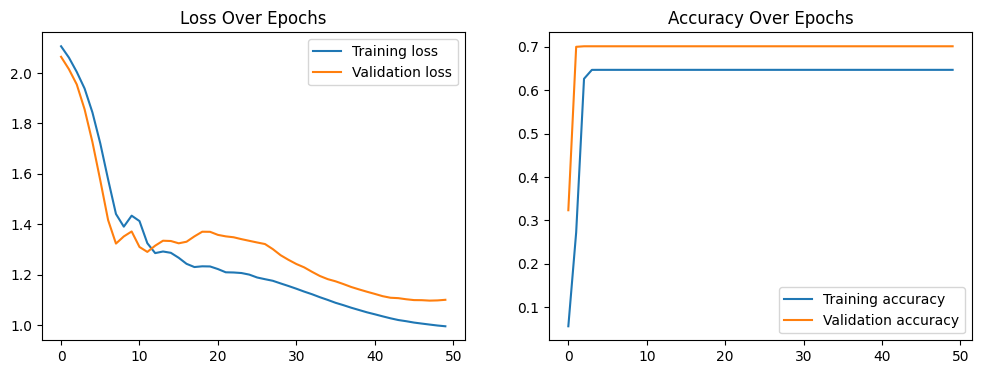

In [26]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [27]:
###### Tesing diferent SGD optimizer @8 Epochs ############
from keras.optimizers import SGD


model = multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(optimizer=SGD(learning_rate=0.05, momentum=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=12, 
    epochs=40, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 256, 256, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 16) 2320        dropout_19[0][0]                 
____________________________________________________________________________________________

In [28]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 37ms/step
Accuracy =  70.10345458984375 %


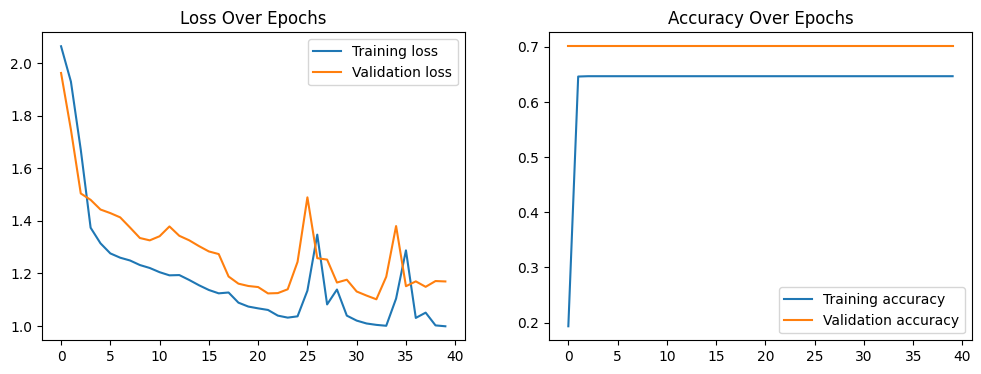

In [29]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


In [ ]:
#################################Room for Improvement:###########################################################

In [ ]:
#Hyperparameter tunning with batch size increase to 16

In [100]:
#Model training
history = model.fit(
    X_train, y_train, 
    batch_size=16, 
    epochs=50, 
    validation_data=(X_test, y_test)
)
model.save(r"C:\Users\user\Desktop\Unett log\model.h5")

Train on 14 samples, validate on 4 samples
Epoch 1/50
14/14 [==============================] - 3s 189ms/step - loss: 0.6461 - accuracy: 0.7244 - val_loss: 0.8702 - val_accuracy: 0.6972
Epoch 2/50
14/14 [==============================] - 2s 176ms/step - loss: 0.6426 - accuracy: 0.7266 - val_loss: 0.8697 - val_accuracy: 0.6971
Epoch 3/50
14/14 [==============================] - 2s 176ms/step - loss: 0.6419 - accuracy: 0.7272 - val_loss: 0.8764 - val_accuracy: 0.6927
Epoch 4/50
14/14 [==============================] - 3s 183ms/step - loss: 0.6409 - accuracy: 0.7262 - val_loss: 0.8661 - val_accuracy: 0.6961
Epoch 5/50
14/14 [==============================] - 3s 197ms/step - loss: 0.6375 - accuracy: 0.7287 - val_loss: 0.8676 - val_accuracy: 0.6972
Epoch 6/50
14/14 [==============================] - 3s 186ms/step - loss: 0.6365 - accuracy: 0.7302 - val_loss: 0.8837 - val_accuracy: 0.6921
Epoch 7/50
14/14 [==============================] - 3s 186ms/step - loss: 0.6456 - accuracy: 0.7239 - val

In [101]:
#Evaluate model

	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 0s 36ms/step
Accuracy =  69.9920654296875 %


In [102]:
#Iou score 
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6174067346065635


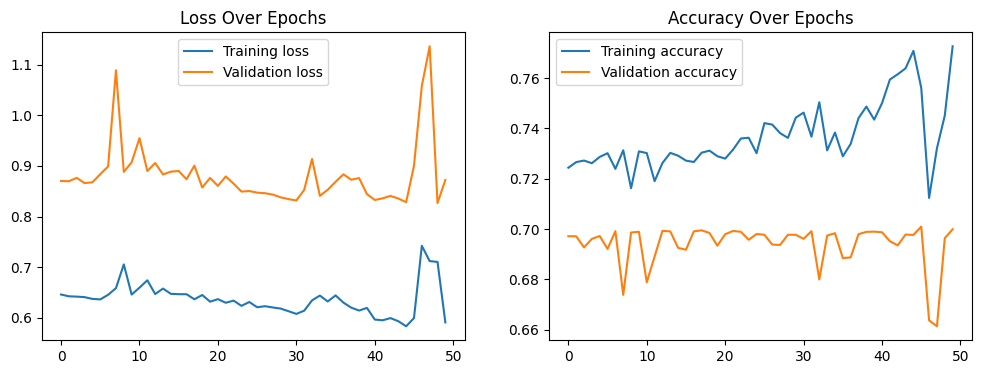

In [103]:
#Trainig and validation loss

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

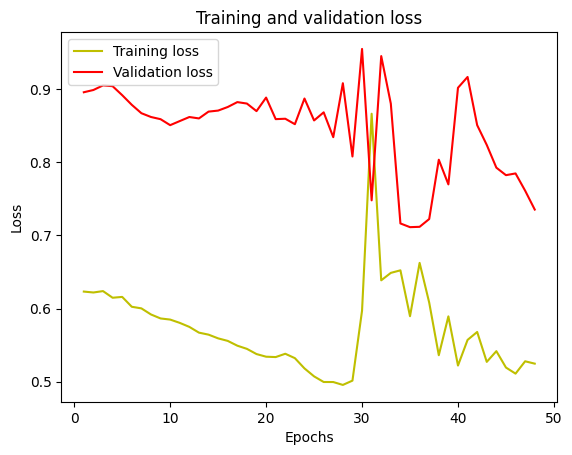

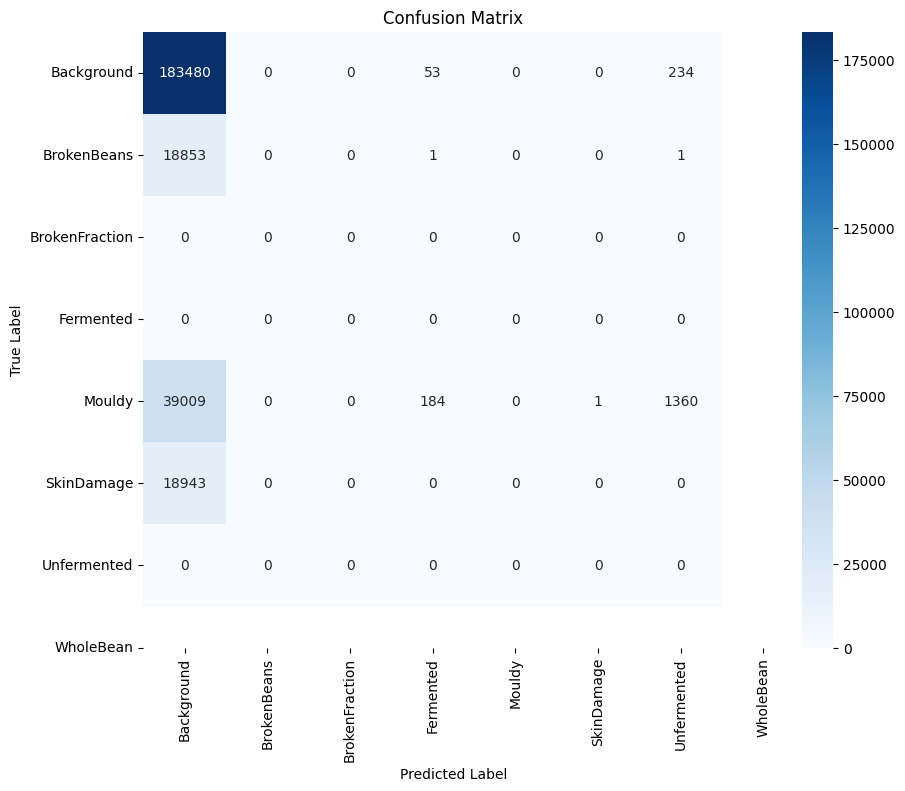

In [106]:
#Confusion matrix

# Predict on the entire test dataset
predictions = model.predict(X_test)

# Flatten the predictions and true masks
y_pred = np.argmax(predictions, axis=3).flatten()
y_true = np.argmax(y_test, axis=3).flatten()


from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))


import seaborn as sns

# Define the class names for the confusion matrix
class_names = ['Background', 'BrokenBeans', 'BrokenFraction', 'Fermented', 'Mouldy', 'SkinDamage', 'Unfermented', 'WholeBean']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

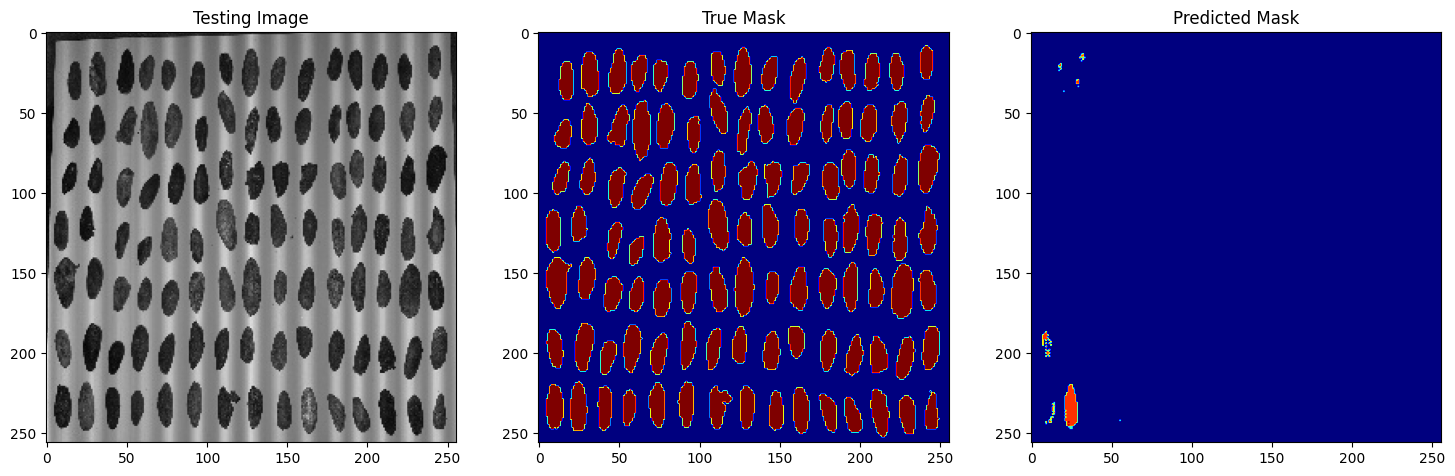

Classes predicted in the image: ['Background', 'Fermented', 'Unfermented', 'WholeBean']


In [107]:
#Mask and prediction class

import random

# Randomly select an image and its corresponding mask from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[random_index]
test_mask = y_test[random_index]


# Expand dimensions of the image to fit the model input shape and predict the mask
test_img_input = np.expand_dims(test_img, axis=0)
predicted_mask = model.predict(test_img_input)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]


# Visualize the testing image, the true mask, and the predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('Testing Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')

plt.show()


# Get unique classes predicted in the image
predicted_classes = np.unique(predicted_mask)
predicted_class_names = [class_names[i] for i in predicted_classes]

print("Classes predicted in the image:", predicted_class_names)

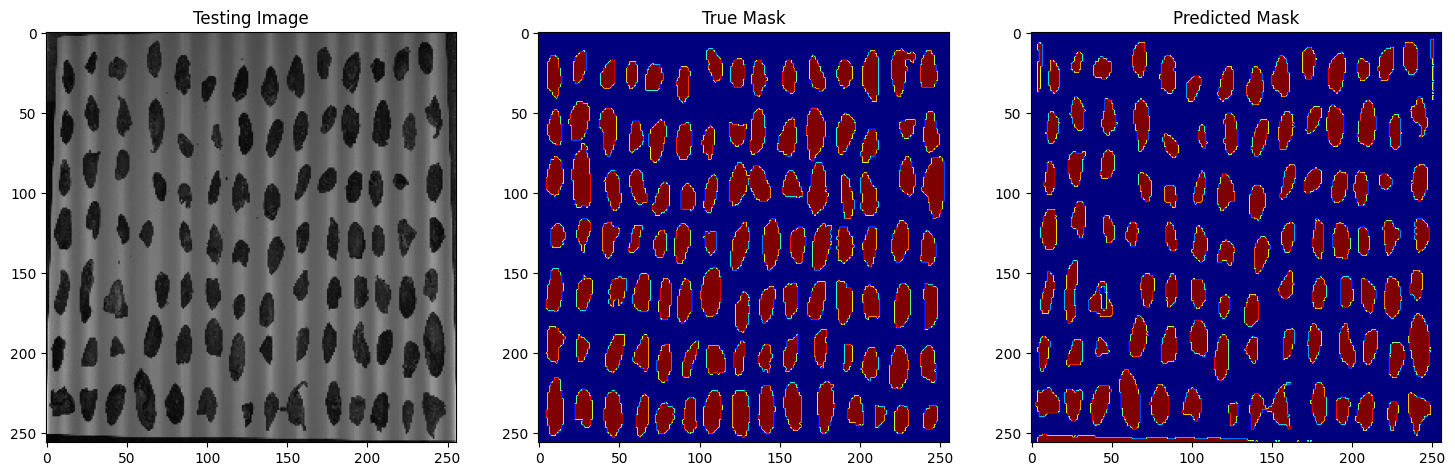

Classes predicted in the image: ['Background', 'Mouldy', 'SkinDamage']


In [81]:
#Mask and prediction class

import random

# Randomly select an image and its corresponding mask from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[random_index]
test_mask = y_test[random_index]


# Expand dimensions of the image to fit the model input shape and predict the mask
test_img_input = np.expand_dims(test_img, axis=0)
predicted_mask = model.predict(test_img_input)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]


# Visualize the testing image, the true mask, and the predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('Testing Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')

plt.show()


# Get unique classes predicted in the image
predicted_classes = np.unique(predicted_mask)
predicted_class_names = [class_names[i] for i in predicted_classes]

print("Classes predicted in the image:", predicted_class_names)

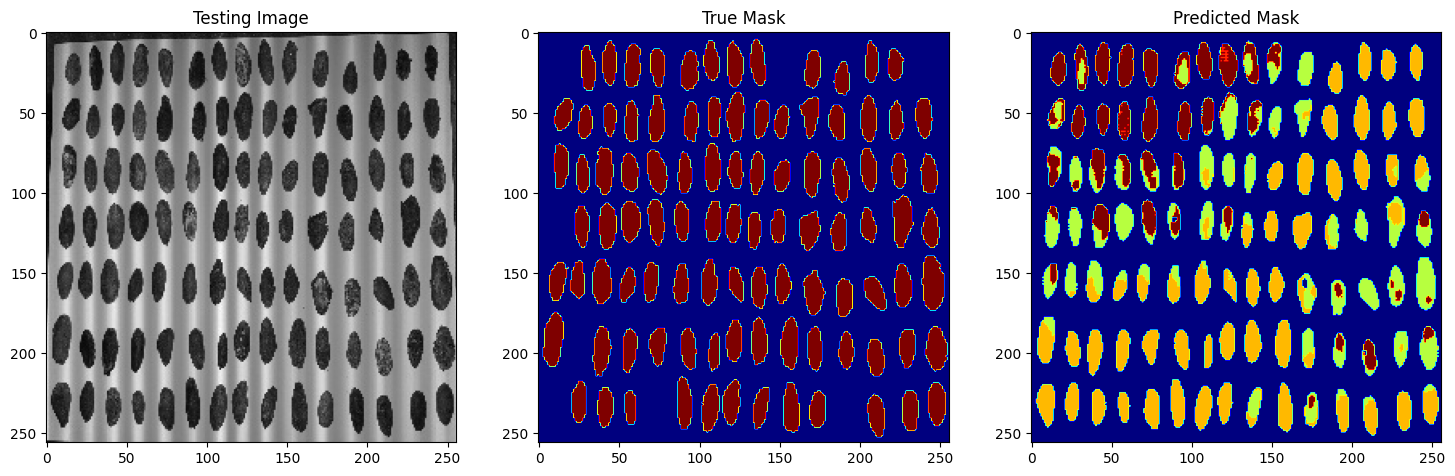

Classes predicted in the image: ['Background', 'Fermented', 'Mouldy', 'SkinDamage', 'Unfermented', 'WholeBean']


In [93]:
#Mask and prediction class

import random

# Randomly select an image and its corresponding mask from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[random_index]
test_mask = y_test[random_index]


# Expand dimensions of the image to fit the model input shape and predict the mask
test_img_input = np.expand_dims(test_img, axis=0)
predicted_mask = model.predict(test_img_input)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]


# Visualize the testing image, the true mask, and the predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('Testing Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')

plt.show()


# Get unique classes predicted in the image
predicted_classes = np.unique(predicted_mask)
predicted_class_names = [class_names[i] for i in predicted_classes]

print("Classes predicted in the image:", predicted_class_names)